# SuperCon Dataset: Estimating Alloy Phase Diagram
---

This is a notebook documenting my experiments with determining the atomic structure of superconducting alloys.



### Dependencies:

To run this notebook you will need to run `pip3 install <dependency>` for all of the packages listed below. These dependencies should be preinstalled in this project's associated Docker container:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import ase
import os
from glob import glob

### Datasets:
Running this notebook requires the metal alloy structure data obtained from the Materials project database (in POSCAR file format). This data can be obtained by running the `./scrape_mp_data.py` script. The directory that this data is scraped into must be configured below:

In [2]:
ALIGNN_ALLOY_DIR = './data/structures/alignn_alloys'

This notebook also requires periodic table data, which can be downloaded below:

* [Periodic Table of Elements (CSV)](https://gist.github.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee)

In [3]:
PTABLE_CSV = '/media/colin/Shared/colin/git/materials-ml/\
jupyter/supercond-exploration/data/PTable/PeriodicTable.csv'

## Parse Structure Data

In [4]:
import re

def build_formula_regex(elements):
    """ builds a formula parsing regex """
    mass_re = '([0-9]*\.[0-9]+|[0-9]+)'
    elem_re = '(' + '|'.join(elements) + ')'
    return re.compile(elem_re + mass_re)

def parse_formula_tokens(formula, regex):
    """ parses a checmical formula consisting of <elem><mass> pairs"""
    tokens = []
    for match in regex.finditer(formula):
        if match.group(1):
            tokens.append((match.group(1), float(match.group(2))))
        else:
            # assume 1.0 if no mass term:
            tokens.append((match.group(1), 1.0))
    return tokens

def formula_from_tokens(tokens):
    """ Constructs a canonical formula from element tokens"""
    tokens = sorted(tokens)
    formula = ''
    for elem, n in tokens:
        formula += str(elem)
        if (n != 1):
            formula += str(n)
    return formula

In [5]:
ptable_df = pd.read_csv(PTABLE_CSV)
elements = list(set(ptable_df['Symbol']))
form_re = build_formula_regex(elements)

## Use ALIGNN model to predict alloy phase diagram:

In [6]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
import torch

def load_model(path):
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    model = ALIGNN(ALIGNNConfig(name="alignn", output_features=1))
    model.load_state_dict(torch.load(path, map_location=device)["model"])
    model.eval()
    
    return model

def model_serve(model, poscar_file):

    cutoff = 8.0
    max_neighbors = 12
    device = "cpu"
    if torch.cuda.is_available():
        device = torch.device("cuda")
    
    atoms = Atoms.from_poscar(poscar_file)
    g, lg = Graph.atom_dgl_multigraph(
        atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
    )
    out_data = (
        model([g.to(device), lg.to(device)])
        .detach()
        .cpu()
        .numpy()
        .flatten()
        .tolist()
    )
    return out_data[0]



In [7]:
alloy_files = glob(os.path.join(ALIGNN_ALLOY_DIR, '*.poscar'))

# build alloy map:
alloy_map = {}
for file in alloy_files:
    filename = os.path.split(file)[1]
    formula = os.path.splitext(filename)[0]
    tokens = parse_formula_tokens(formula, form_re)
    elems = tuple(sorted([ t[0] for t in tokens ]))
    if elems not in alloy_map:
        alloy_map[elems] = []
    alloy_map[elems].append((tokens, file))

In [10]:
BINARY_ALLOY = ('Nb', 'Ge')
ALIGNN_TC_MODEL_PATH = './data/structures/alignn_output/checkpoint_64.pt'

alignn_model = load_model(ALIGNN_TC_MODEL_PATH)

alloy_key = tuple(sorted(BINARY_ALLOY))
tc_phases = []

# query model with intermediate compounds/alloys:
for tokens, alloy_file in alloy_map[alloy_key]:
    pred_tc = model_serve(alignn_model, alloy_file)
    tc_phases.append((tokens, pred_tc))
    print(alloy_file, pred_tc)

# also query elemental "endpoints" of the phase space:
for elem in BINARY_ALLOY:
    elems_key = (elem,)
    if elems_key in alloy_map:
        tokens, alloy_file = alloy_map[elems_key][-1]
        pred_tc = model_serve(alignn_model, alloy_file)
        tc_phases.append((tokens, pred_tc))
        print(alloy_file, pred_tc)

./data/structures/alignn_alloys/Nb0.1Ge0.9.poscar 3.0333502292633057
./data/structures/alignn_alloys/Nb0.2Ge0.8.poscar 2.954408884048462
./data/structures/alignn_alloys/Nb0.3Ge0.7.poscar 3.708378791809082
./data/structures/alignn_alloys/Nb0.4Ge0.6.poscar 4.520713806152344
./data/structures/alignn_alloys/Nb0.5Ge0.5.poscar 7.193614959716797
./data/structures/alignn_alloys/Nb0.6Ge0.4.poscar 7.193614959716797
./data/structures/alignn_alloys/Nb0.7Ge0.3.poscar 5.441568851470947
./data/structures/alignn_alloys/Nb0.8Ge0.2.poscar 4.233950614929199
./data/structures/alignn_alloys/Nb0.9Ge0.1.poscar 3.6132988929748535
./data/structures/alignn_alloys/Nb1.poscar 8.719191551208496
./data/structures/alignn_alloys/Ge1.poscar 2.4166994094848633


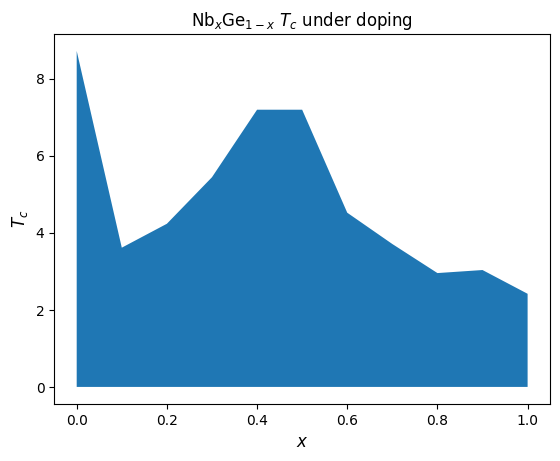

In [18]:
tcs = []
vecs = []

for (tokens, tc) in sorted(tc_phases):
    composition = { e : n for (e,n) in tokens }
    vector = np.array([ 
        composition[e] if e in composition else 0.0
        for e in BINARY_ALLOY 
    ]) / np.sum(list(composition.values()))
    
    tcs.append(tc)
    vecs.append(vector)

x0 = np.array([[0.],[1.]])
x = np.array([ v @ x0 for v in vecs ])

plt.ylabel(r'$T_c$', fontsize=12)
plt.xlabel(r'$x$', fontsize=12)
plt.title(r'Nb$_x$Ge$_{1-x}$ $T_c$ under doping')
plt.fill_between(x.flatten(), tcs)
plt.show()
